## Note:

- If output layer is same like hidden (use sigmoids).. NO Accurate reconstructed output
- Best results when: 

> hidden: sigmoid 

> output: RELU, and 

> inputs normalized(0,1) to be suitable for sigmoid

> no reguliazation

In [1]:
using PyPlot
using StatsBase
using Distributions
include("MNIST.jl")

MNIST

# Reading MNIST Data
and dividing it to :
- unlabelled data (all MNIST images >5)
- labelled data (other images)

In [2]:
data,labels=MNIST.traindata();
unlabeled_index = find(labels.>= 3);
labeled_index = find(labels.< 5);

In [3]:
unlabeled_data = data[:, unlabeled_index]';
size(unlabeled_data)

(41377,784)

# Normalization(between 0 and 1)

In [4]:
for i=1:size(unlabeled_data,2)
    maxi=maximum(unlabeled_data[:,i])
    mini=minimum(unlabeled_data[:,i])
    unlabeled_data[:,i]= (unlabeled_data[:,i].-mini)./(maxi-mini +0.001)
end

# > OR :Whitening by PCA (0 mean- unit variance)

In [5]:
# xyzMean = mean(unlabeled_data,1)
# trainZeroMean= training_data .- xyzMean # 1. zero mean data
    
# sigma=cov(trainZeroMean) # sigma is the covraince becuase data has zero mean
# lamda= eigvals(sigma)
# lamda= reshape(lamda,1,length(lamda))


# trainUnitVariance= trainZeroMean ./ sqrt(lamda+0.001); #2. unit variance

# unlabeled_data=trainUnitVariance

# Parameters

In [6]:
k= 180                            # number of highest activations
hiddenSize=300                     # number of hidden nodes in layer 2
visibleSize=size(unlabeled_data,2) # size of first layer (input)&& output layer
lamda=0.0                         # regulization param
alpha= 0.001                    # learning rate
iterations=2000                 
batchSize=50                   # number of examples at each iteration of the training
numBatches= floor(Int,size(unlabeled_data,1)/batchSize)   # number of batches that cover all unlabeled_data


827

# Basic Functions

In [7]:
# Initiliaze weights within (-r,r)
function initialize()
    r= sqrt(6)/ sqrt(hiddenSize+visibleSize+1);
    dist=Uniform(-r,r)
#     dist=Uniform(0,1)
    W1= rand(dist,visibleSize,hiddenSize)#*2*r -r; # Uniform 
    W2= rand(dist,hiddenSize,visibleSize)#*2*r - r;
    b1= zeros(hiddenSize)';
    b2= zeros(visibleSize)';
    W1,W2,b1,b2
end


initialize (generic function with 1 method)

In [8]:
function shuffle_data(data)
    m,n=size(data)
    indxes=shuffle(1:m)
    view(data,indxes,1:n) # view doesn't copy the array, just a subarray
end

shuffle_data (generic function with 1 method)

In [9]:
# Activation Function and KL-Divergence
sigmoid(x)= 1/(1+exp(-x));
RELU(x)=  max(0,x)
RELUDerv(x)= sigmoid(x)
sigmoidDerv(x)= sigmoid(x) * (1-sigmoid(x));


# Autoencoder Forward Pass

In [10]:
function forward_step(x,W1,W2,b1,b2,k)
    a1=x #m*features
    m= size(x,1)
    
    z2=a1*W1 .+b1 #+ repmat(b1,m)
    a2=sigmoid.(z2) # m*hidden.. each column is activation of 1 node over all examples
  
    z3= a2*W2 .+ b2 #repmat(b2,m)
    a3=RELU.(z3) # m*visible .. Each row corresponds to one example
    
    ## Select first K highest activations at each example.. and make others zeros
    for i in 1:size(a2,1)
        indxes=sortperm(a2[i,:],rev=true)
        a2[i,indxes[k+1:end]]=0.0
    end
        
    return a1,a2,a3,z2,z3
end

forward_step (generic function with 1 method)

# Helper Functions for backward pass:
### - will be called per each example

In [11]:
### Gets delta at last layer in the network

# y is vector of all outputs of each training example
# a is activation of all neurons in last layer
# z is the inputs to each neuron of last layer
# output must be vector with size of output neurons
function get_lastError(y,a,z)
    delta = -(y-a) .* RELUDerv.(z)
#     delta = -(y-a) .* sigmoidDerv.(z)
end

get_lastError (generic function with 1 method)

In [12]:
### Get delta at other layers (not the last).. and no delta for the first layer

# OUTPUT deltai will be number of neurons in layer l to be then collected in one big delta i with m*number of neurons in l
# delta j and W[i,:] must be both column vectors to be dotted
# deltaj: the error of the next layer (it is m* number of neurons in the layer l+1)
# zi : the inputs to current layer before applying the activation function on them (it is m* number of neurons in layer l)
# W : weights matrices from layer l to layer l+1 (size: neurons in l * neurons in l+1)
function get_error(zi,deltaj,W) 
    deltai=zeros(length(zi))
    for i in 1:length(zi)
        deltai[i]= dot(W[i,:],deltaj)  * sigmoidDerv(zi[i])  # deltai
    end
    deltai
end

get_error (generic function with 1 method)

In [13]:
### Get partial deravtives of weights [Wij: between layer i and layer j ]

# deltaj (in next layer.. vector of deltas for each neuron)
# ai : vector of activations for each neuron in hidden
# make them a row vector and a is column vector so output is matrix
function partialDerv_W(deltaj,ai)
    partial_derv= ai.*deltaj'
end

partialDerv_W (generic function with 1 method)

In [14]:
### Get partial deravtives of biases [bi: that depends on nect layer's error deltaj]

# #  deltaj is vecotr of next layer errors
function partialDerv_b(deltaj) 
    partial_derv= deltaj'
end

partialDerv_b (generic function with 1 method)

# Autoencoder Backward Pass

In [15]:
function batch_gradient_descent(a1,a2,a3,z2,z3,W1,W2,b1,b2)
   
    m=size(a1,1)
    W1_derv_matrix=zeros(size(W1))
    W2_derv_matrix=zeros(size(W2))
    b1_derv_matrix=zeros(size(b1))
    b2_derv_matrix=zeros(size(b2))
    normalCost=0

    for i =1:m
        normalCost+= 0.5*sqrt(sum((a3[i,:]-a1[i,:]).^2)) # squared reconstruction  error
        delta3= get_lastError(a1[i,:],a3[i,:],z3[i,:]) 
        delta2= get_error(z2[i,:],delta3,W2)

        W2_derv= partialDerv_W(delta3, a2[i,:])
        W1_derv= partialDerv_W(delta2, a1[i,:])
        b2_derv= partialDerv_b(delta3)
        b1_derv= partialDerv_b(delta2)

        W1_derv_matrix += W1_derv
        W2_derv_matrix += W2_derv
        b1_derv_matrix += b1_derv
        b2_derv_matrix += b2_derv

    end

    regCost= (lamda/2)*sum(W1.^2)*sum(W2.^2) 
    TotalCost = normalCost/m + regCost 

    W1= W1- alpha* (W1_derv_matrix/m  + lamda*W1)
    W2= W2- alpha* (W2_derv_matrix/m  + lamda*W2)
    b1= b1- alpha* (b1_derv_matrix/m )
    b2= b2- alpha* (b2_derv_matrix/m )
    
    TotalCost,W1,W2,b1,b2
    
end

batch_gradient_descent (generic function with 1 method)

# Testing Autoencoder

In [16]:
AllCosts=Array(Float64,0)
currentBatch=0
from=1
finalActivations=[]
finalOutput=[]
finalBatch=[]
W1,W2,b1,b2 = initialize()
unlabeled_data= shuffle_data(unlabeled_data)

for i=1:iterations
    currentBatch+=1
    # if iterations are more than one pass over all data, pass again over the data after shuffling
    if currentBatch>numBatches 
        from=1
        unlabeled_data= shuffle_data(unlabeled_data)
    end
    # the end index of the batch
    to = from+batchSize-1
    #Get current batch of the unlabeled data
    batch=unlabeled_data[from:to,:]
    a1,a2,a3,z2,z3=forward_step(batch,W1,W2,b1,b2,k)
    cost,W1,W2,b1,b2= batch_gradient_descent(a1,a2,a3,z2,z3,W1,W2,b1,b2);
#     println("weights $(W1[1:3,1:3])")
#     println("activations $(z2[1:3,1:3])")
#     println(cost)
    push!(AllCosts,cost)
    if i==iterations
        finalActivations=a2
        finalOutput=a3
        finalBatch=batch
    end
    from = to
end
# The final minimum cost is:
AllCosts[end]

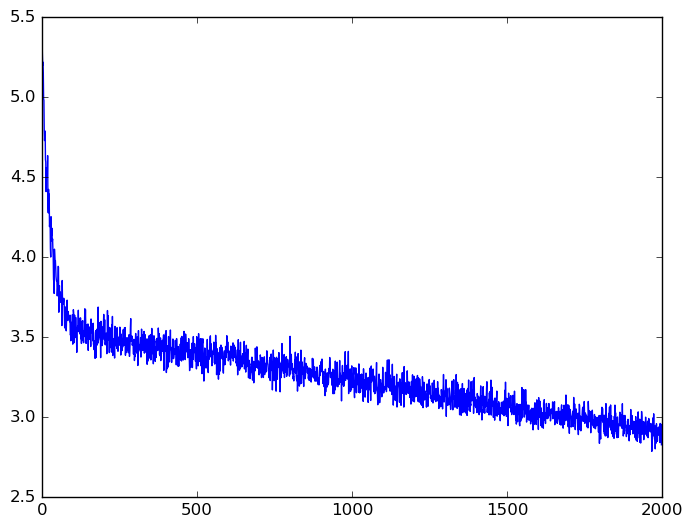

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa047d42990>

In [17]:
plot(AllCosts[2:end])

# Autoencoder Visulaization

In [18]:
using Images
using ImageView


  likely near In[19]:3


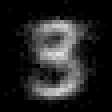

In [19]:
# the final output layer's values (ex the 25th example in last batch)
t= reshape(finalOutput[50,:],28,28);
tt=convert(Image{Gray},t)

  likely near In[20]:3


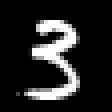

In [20]:
# the real output (ex the 25th example in last batch)
t= reshape(finalBatch[50,:],28,28);
tt=convert(Image{Gray},t)

  likely near In[21]:3


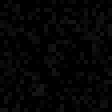

In [21]:
# the last weights values
t= reshape(W2[30,:],28,28);
tt=convert(Image{Gray},t)